# Customer Lifetime Value Model
Customer Lifetime Value (CLV) is the total profit of the entire relationship with the customer. It takes into account costs to attract, service, and maintain the customer. It also considers customer transactions, both the number of times and values. Though not easily tracked, it may also include things like customer network effects such as word-of-mouth. We can think of CLV as an effort to capture the health of the relationship between the customer and the business.

Business context is important when modeling CLV. Let's consider contractual vs non-contractual and discrete vs continuous purchases. In contractual-type businesses, customer 'death' can be observed and CLV is often modeled using survival-based approaches. On the other hand, in non-contractual business, the customer 'death' is unobserved and customer lifetime distribution is often modeled via exponential models. Discrete purchases occur at fixed periods or frequencies while continuous purchases can happen at any time.

What happens we stop thinking about business results as a flow dollars but as a flow of dollars attached to customers?

## 1.0 Problem and purpose
Let's analyze the company at the grain of a customer. Our main question is what's their lifetime spend? We care about this because:
- CLV can help identify with customer segmentation and identify the most profitable customers
- CLV can help identify traits and features of valuable customers
- CLV can help determine how to allocate resources among customers
- CLV can help evaluate what a company should pay to acquire customer relationship
In summary, CLV can help with decisions that affect long-term health of customer relationships. 

## 2.0 Dataset(s)
Two datasets are used here. 
1. A transactional dataset that was split into a calibration and hold-out datasets. It has 15.273 entries. It is artificially created.
2. A summary dataset with frequency, recency, and age dataset from CDNOW. CDNOW is a widely used dataset for CLV modeling. It is data from an early online music retailer. It has 2357 entries. 


## 3.0 Challenge(s) and approach
The challenge is that we're working with a  non-contractual and continuous purchase business model. This is an important distinction. In a contractual setting, we observe the time at which the customers "die" or become non-customers. In a non-contractual setting, the time at which a customer becomes inactive is unobserved. 

How do we differentiate between those customers who have ended their relationship with the non-contractual firm versus those who are simply in the midst of a long hiatus between transactions? In this [video](https://www.youtube.com/watch?v=guj2gVEEx4s), Professor Peter Fader from Wharton Business School explained that three attributes are most important to measure in this setting:
1. Recency - the date of the customer's last transaction
2. Frequency - the number of times the customer has bought from the company in a specified time period
3. Monetary value - the average value of transactions of the customer in a specified time period

## 4.0 Implementation

In [34]:
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

In [3]:
data = load_cdnow_summary(index_col=[0])
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [44]:
data.describe()

,frequency,recency,T,predicted_purchases
count,2357.000000,2357.000000,2357.000000,2.357000e+03
mean,1.042427,6.845787,32.715829,2.212434e-02
std,2.190014,10.731400,3.326906,4.419791e-02
min,0.000000,0.000000,27.000000,1.552359e-11
25%,0.000000,0.000000,29.860000,6.313261e-03
50%,0.000000,0.000000,32.710000,7.135958e-03
75%,1.000000,12.000000,35.430000,1.928588e-02
max,29.000000,38.430000,38.860000,7.106233e-01


In [5]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

In [7]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

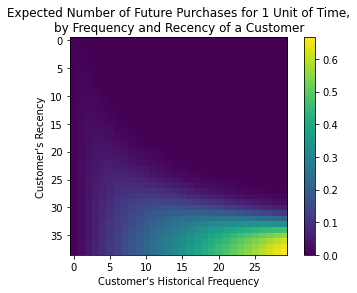

In [9]:
### Recency-Frequency Matrix
plot_frequency_recency_matrix(bgf)

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

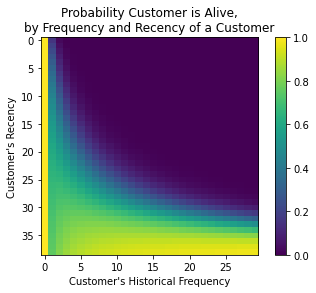

In [11]:
### Probability Alive Matrix
plot_probability_alive_matrix(bgf)

In [12]:
# Highest expected purchases in the next period
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

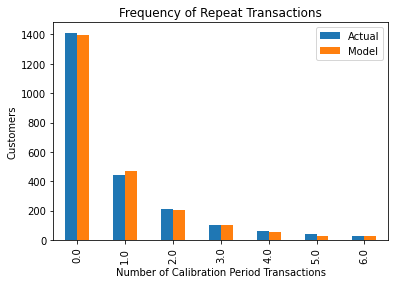

In [14]:
# Model fit
plot_period_transactions(bgf)

In [16]:
# Transactional datasets: calibration and hold-out
transaction_data = load_transaction_data()
transaction_data.head()

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


In [18]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


In [19]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

In [21]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )

In [23]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121.0
1,0.0,0.0,103.0,0.0,121.0
2,6.0,142.0,171.0,0.0,121.0
3,0.0,0.0,26.0,0.0,121.0
4,2.0,9.0,62.0,0.0,121.0


<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

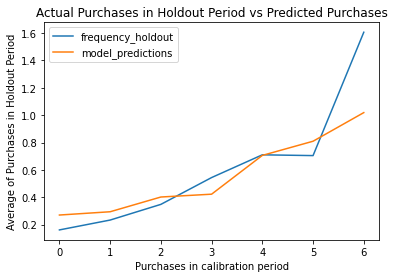

In [25]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [29]:
# Predict purchases in 12 periods for a given customer
t = 12
individual = summary.iloc[20]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.06883477343119658

In [31]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


In [32]:
# Assumption: customer has at least 1 repeat transaction
# Keep only data with non-zero frequency
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

In [33]:
# Assumption: there is no relationship between the monetary valuee and the frequency
# Check correlation is close to zero
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [35]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
ggf

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [36]:
# Estimate average transaction value
ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [42]:
# Conditional expected average lifetime value of customers
print("Expected conditional average profit: %s \nAverage profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.252958176050115 
Average profit: 35.07855179704017


In [45]:
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])
clv_dcf = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [53]:
clv_dcf.sort_values(ascending=False).head() 

customer_id
509     3949.004426
1081    3360.961978
1516    3142.343817
1560    2714.880832
1981    2548.198826
Name: clv, dtype: float64

In [55]:
clv_dcf.head()

customer_id
1    140.096218
2     18.943466
3     38.180575
4     38.180575
5     38.180575
Name: clv, dtype: float64

## 5.0 Results discussion
The Frequency-Recency Matrix (Expected Number of Future Purchases for 1 Unit of Time, by Frequency and Recency of a Customer) shows that the best customers have been active for over 60 weeks and have made over 20 purchases.

The Probability Alive Matrix (Probability Customer is Alive, by Frequency and Recency of a Customer) shows that probability of customers being "alive" or not inactive. The high recency and low frequency combination is a sign that the customer is active. As frequency tapers, so does the probability the customer staying active.

The Highest Expected Purchases in the next period shows that one customer who has made 26 purchases and bought recent is probably going to buy again in the next period.

The Frequency of Repeat transactions plot show actual vs the model's prediction. Here, we compare our data versus artificial data simulated with fitted model's parameters.The actual and the simulated data line up well.

We could also segregate transactional datasets, into calibration and hold-out datsets to see how the model performs on previously unseen data. This is akin to cross-validation in machine learning. We fit on the _cal columns and test on the _holdout columns. The resulting plot illustrates how the model performs on the hold-out dataset.

We could predict what an individual's future purchase might look like. When we tried to predict purchases in 12 periods for a given customer, we see that customer at index 20 will probably make a purchase in 12 periods. 

Finally, the Gamma-Gamma model is used to calculate the CLV. We saw  the conditional, expected average lifetime value of customers. The expected conditional average profit is 35.252958176050115. The average profit is 35.07855179704017. Finally the total CLV is computed using the discounted cashflow method adjusting for cost of capital in the final cell.


## 6.0 Conclusion
Our main question was what is the lifetime spend of our customers? We answered that directly in the final cells. 

With this analyses, we can help segment and identify the most profitable customers. We can help identify traits and features of valuable customers. It can also help determine how to allocate resources among customers existing customers and in acquiring new ones.


## 7.0 References

Fader, Peter S. and Bruce G.,S. Hardie, (2001), "Forecasting Repeat Sales at CDNOW: A Case Study," Interfaces, 31 (May-June), Part 2 of 2, S94-S107.

Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). "Counting your customers" the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284. https://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

Schmittlein, D.C., Morrison, D.G., Colombo, R. (1987) "Counting Your Customers: Who Are They and What Will They Do Next?", Management Science, 33(1), pp.1-24. https://www.jstor.org/stable/2631608?seq=1#page_scan_tab_contents
